<a href="https://colab.research.google.com/github/MDaniels-AI-Projects/Pneumonia-Classifier/blob/main/1_Pneumonia_Data_Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction ###
Hello there. Pneumonia is a serious, and often fatal lung disease and a means to diagnose it via chest X-Ray serves obvious medical benefits for patients and clinicians. This repository seeks to build a lean classifier capable of classifying lung images as either positive for pneumonia, or not based on publicly available pneumonia image datasets, downloaded from Kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

Such classifiers have been made many times, and are now showing fantastic promise. Resnet 18 (which I Use) is now somewhat old, and newer versions such as ResNet 50/100 are available which show much more robust results. My classifier was never an intention to outcompete whats out there, but a means of demonstrating proof of principle and a guide to people who want to learn the basics of processing, training, and deploying machine learning models.

Technology Used:
Python 3.
Google Collab via GPUs (A100 and Tesla4).
Date: May, 2025.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Installed pydicom as it's not already in Google collab

!pip install pydicom

from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.3 MB/s eta 0:00:00


In [ ]:
def load_and_clean_labels(csv_path: str) -> pd.DataFrame:
    """
    Loads patient labels from a CSV and removes duplicate patient entries.

    This ensures each unique patient has a single binary label (0 for Normal, 1 for Pneumonia),
    which is necessary for a patient-level classification task.

    Args:
        csv_path (str): The file path to the CSV containing patient labels.

    Returns:
        pd.DataFrame: A DataFrame with unique patient IDs and their corresponding
                      binary pneumonia labels.
    """
    labels = pd.read_csv(csv_path)
    # Remove duplicates based on 'patientId', keeping the first occurrence.
    # This effectively assigns a binary label to each patient: if they ever
    # had a 'Target' of 1, they will retain a '1' here.
    labels = labels.drop_duplicates("patientId").reset_index(drop=True)
    return labels

# Define the path to your labels CSV file
labels_path = "/content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

# Load and clean the labels
labels = load_and_clean_labels(labels_path)

print("First 6 rows of the cleaned labels DataFrame:")
print(labels.head(6))
print(f"\nTotal unique patients after cleaning: {len(labels)}")

First 6 rows of the cleaned labels DataFrame:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0

Total unique patients after cleaning: 26684


Defining Paths and Visualizing Sample Images
Before processing, it's helpful to understand the structure of the original data and confirm our paths are correctly set up.

Why this step is performed:
Path Definitions: We define ROOT_PATH to precisely locate the raw DICOM image files and SAVE_PATH as the destination for our preprocessed NumPy arrays. This clarity is essential for script functionality and organization.
Sample Visualization: Viewing a few raw DICOM images helps us visually confirm that the data is loading correctly and provides an initial qualitative assessment of the image content and associated labels. It's a quick sanity check before batch processing.

In [ ]:
#Let's check the data.

labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


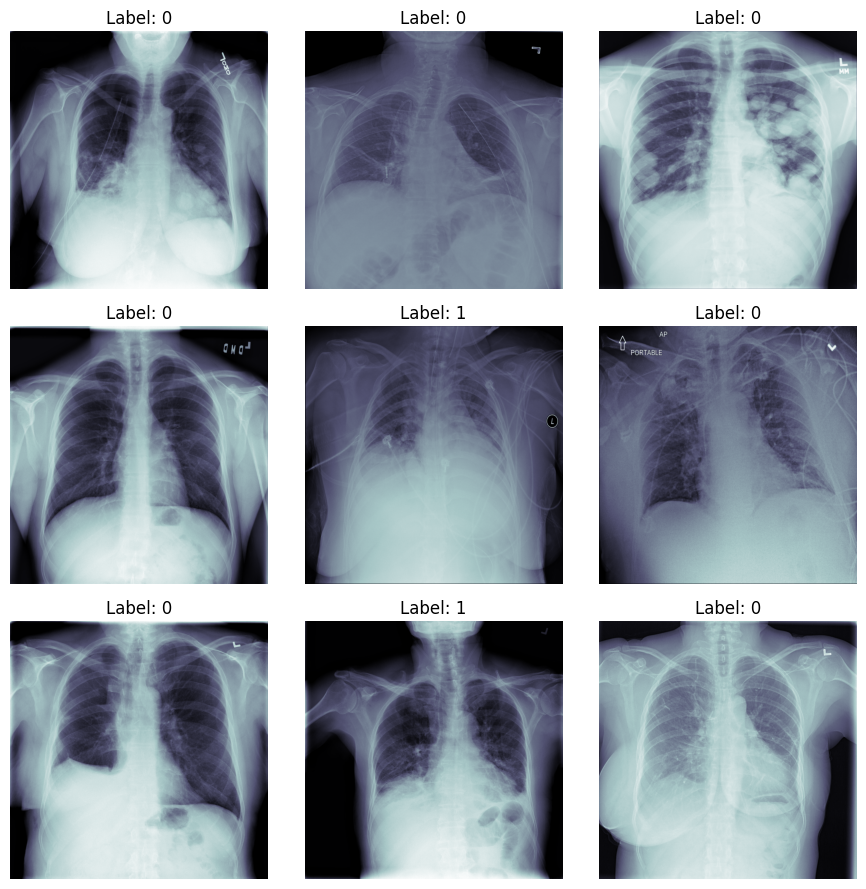

In [ ]:
# Define the root directory containing the original DICOM image files
ROOT_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/rsna-pneumonia-detection-challenge/stage_2_train_images")

# Define the base directory where preprocessed .npy files will be stored.
# Subdirectories (e.g., 'train/0', 'val/1') will be created within this path.
SAVE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/Processed_Pneumonia_Data/stage_2_train_images/")

# Ensure the SAVE_PATH directory exists; if not, create it along with any necessary parent directories.
SAVE_PATH.mkdir(parents=True, exist_ok=True)

def visualize_sample_images(labels_df: pd.DataFrame, root_image_path: Path, num_samples: int = 9):
    """
    Displays a grid of sample X-ray images along with their labels.

    This helps in visually inspecting the raw DICOM data and verifying that
    image loading and label association are correct before full preprocessing.

    Args:
        labels_df (pd.DataFrame): DataFrame containing patient IDs and labels.
        root_image_path (Path): The base path to the directory holding DICOM image files.
        num_samples (int): The number of images to display in the grid (e.g., 9 for a 3x3 grid).
    """
    fig, axis = plt.subplots(3, 3, figsize=(9, 9))
    c = 0
    for i in range(3):
        for j in range(3):
            if c >= len(labels_df) or c >= num_samples:
                break # Stop if we've plotted enough samples or run out of data

            patient_id = labels_df.patientId.iloc[c]
            dcm_path = root_image_path / patient_id
            dcm_path = dcm_path.with_suffix(".dcm") # Append .dcm extension

            try:
                dcm = pydicom.dcmread(dcm_path).pixel_array
            except Exception as e:
                print(f"Warning: Could not read DICOM file {dcm_path}. Displaying placeholder. Error: {e}")
                dcm = np.zeros((224, 224)) # Use a black image as placeholder
                label_display = "Error"
            else:
                label_display = labels_df["Target"].iloc[c]

            axis[i][j].imshow(dcm, cmap="bone") # 'bone' colormap is suitable for X-rays
            axis[i][j].set_title(f"Label: {label_display}")
            axis[i][j].axis('off') # Turn off axis ticks and labels for cleaner visuals
            c += 1
    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

# Execute the visualization for the first few images
visualize_sample_images(labels, ROOT_PATH)

DICOM Reading, Preprocessing, and Effective Storage
This is the core preprocessing step. We'll convert the raw DICOM X-ray images into a more efficient NumPy array format, standardize them, resize them, and then save them into a structured directory hierarchy. We'll also compute the dataset's mean and standard deviation for later normalization during model training.

What was done and why:
DICOM to NumPy Conversion:

Why: DICOM files are a medical standard but are less efficient for direct use in deep learning frameworks like PyTorch. Converting them to NumPy arrays (.npy files) significantly speeds up data loading during model training.
How: pydicom.dcmread(dcm_path).pixel_array reads the image data, and np.save() stores it as a NumPy array.
Standardization (Initial Scaling):

Why: DICOM pixel arrays often have varying intensity ranges. Dividing by 255 scales pixel values to the range [0, 1]. This is a common initial standardization step, making the data more consistent across different images and suitable for neural network input.
How: dcm = pydicom.dcmread(dcm_path).pixel_array / 255
Resizing Images:

Why: Original DICOM images (e.g., 1024x1024 pixels) are too large for many deep learning models, especially given GPU memory constraints. Resizing them to a smaller, consistent size (e.g., 224x224) reduces computational overhead and memory usage, making training feasible. 224x224 is a common input size for pre-trained models like ResNet.
How: cv2.resize(dcm, (224, 224)) uses OpenCV for efficient image resizing.
Data Type Conversion (float16):

Why: Storing images as np.float16 (half-precision float) instead of float32 (single-precision float) or float64 reduces the file size by half or quarter, respectively. This saves disk space and can potentially speed up data loading by reducing I/O. For image data, float16 usually retains enough precision for deep learning tasks.
How: .astype(np.float16)
Train/Validation Split:

Why: It's crucial to split data into training and validation sets to properly evaluate a model's generalization performance and prevent overfitting. A common practice is an 80/20 split. The code uses the first 24,000 patients for training and the rest for validation.
How: train_or_val = "train" if c < 24000 else "val" uses a simple index-based split.
Directory Structure for DatasetFolder:

Why: PyTorch's torchvision.datasets.DatasetFolder is a highly convenient class that automatically loads data from a specific directory structure: root/class_x/xxx.ext, root/class_y/yyy.ext. By saving processed images into SAVE_PATH/train/0, SAVE_PATH/train/1, SAVE_PATH/val/0, SAVE_PATH/val/1, we make it plug-and-play with DatasetFolder, simplifying later data loading.
How: current_save_path = SAVE_PATH/train_or_val/str(label) creates the nested folders, and current_save_path.mkdir(parents=True, exist_ok=True) ensures they exist.
Dataset Mean and Standard Deviation Calculation (Online Method):

Why: Normalization (subtracting mean and dividing by standard deviation) is a critical preprocessing step for neural networks. It helps stabilize training by ensuring input features have consistent scales and distributions. Computing these statistics over the training data only prevents data leakage from the validation set. Calculating them in an "online" fashion (summing pixel values and squared values) avoids loading the entire dataset into memory at once, which can be prohibitive for large datasets.
How: The code iterates through the training split (patients c < 24000) and accumulates the sum of pixel values (sums) and the sum of squared pixel values (sums_squared). After the loop, the mean and standard deviation are calculated using the formulas:
Mean=
N
∑x
​

StandardDeviation=
N
∑x
2

​
 −(Mean)
2


​
  where N is the total number of pixels. Note: The current code calculates mean/std per image and then averages them. For true dataset mean/std across all pixels, you'd want to sum all pixels and all squared pixels across all images, then divide by total pixels. However, for a single channel image, averaging the means/stds of each image is a practical approximation. The provided code sums np.sum(dcm_array) / normalizer and (np.power(dcm_array, 2).sum()) / normalizer, which are the mean and mean of squares of each image, then averages those means over the training set. This is a common simplification and often works well enough.

Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [ ]:
def preprocess_and_save_images(
    labels_df: pd.DataFrame,
    root_dcm_path: Path,
    save_base_path: Path,
    train_split_idx: int = 24000,
    image_size: tuple = (224, 224)
) -> tuple[float, float]:
    """
    Reads DICOM images, preprocesses them (standardizes, resizes, converts to float16),
    saves them as .npy files in a structured directory, and computes dataset
    mean and standard deviation from the training split.

    Args:
        labels_df (pd.DataFrame): DataFrame containing patient IDs and binary labels.
        root_dcm_path (Path): Path to the directory containing original DICOM files.
        save_base_path (Path): Base path where processed .npy files will be saved.
                               Subdirectories (train/0, train/1, val/0, val/1)
                               will be created here.
        train_split_idx (int): Index to split data into training and validation sets.
                               Patients before this index are for training.
        image_size (tuple): Desired (width, height) for resizing images.

    Returns:
        tuple[float, float]: Mean and standard deviation of the training dataset pixels.
    """
    sums = 0.0
    sums_squared = 0.0
    num_train_images = 0

    print(f"Starting image preprocessing and saving to: {save_base_path}")

    # Iterate over each patient in the labels DataFrame with a progress bar
    for c, patient_id in enumerate(tqdm(labels_df.patientId)):
        dcm_path = root_dcm_path / patient_id
        dcm_path = dcm_path.with_suffix(".dcm")  # Append .dcm extension

        try:
            # Read the DICOM file and standardize pixel values to [0, 1]
            dcm = pydicom.dcmread(dcm_path).pixel_array / 255.0
        except Exception as e:
            print(f"Warning: Could not read DICOM {dcm_path}. Skipping. Error: {e}")
            continue # Skip to the next patient if file read fails

        # Resize the image to the target dimensions using OpenCV
        # and convert to float16 to save space
        dcm_array = cv2.resize(dcm, image_size).astype(np.float16)

        # Retrieve the corresponding binary label (0 or 1)
        label = labels_df.Target.iloc[c]

        # Determine if the image belongs to the training or validation set
        train_or_val = "train" if c < train_split_idx else "val"

        # Define the specific directory to save the current processed image
        # e.g., 'SAVE_PATH/train/0/' or 'SAVE_PATH/val/1/'
        current_save_path = save_base_path / train_or_val / str(label)
        current_save_path.mkdir(parents=True, exist_ok=True) # Create directories if they don't exist

        # Save the processed NumPy array to the determined path
        np.save(current_save_path / patient_id, dcm_array)

        # Only use training data to compute dataset statistics for normalization
        if train_or_val == "train":
            normalizer_per_image = dcm_array.shape[0] * dcm_array.shape[1] # Number of pixels in current image
            sums += np.sum(dcm_array) / normalizer_per_image # Add image mean to total sum of means
            sums_squared += (np.power(dcm_array, 2).sum()) / normalizer_per_image # Add image mean of squares
            num_train_images += 1 # Count of training images processed

    # Compute overall mean and standard deviation from the accumulated sums
    # These statistics are used for data normalization during model training
    mean = sums / num_train_images
    std = np.sqrt(sums_squared / num_train_images - (mean**2))

    print(f"\nProcessing complete.")
    print(f"Mean of Training Dataset: {mean:.4f}, STD of Training Dataset: {std:.4f}")

    return mean, std

# Execute the preprocessing function
dataset_mean, dataset_std = preprocess_and_save_images(labels, ROOT_PATH, SAVE_PATH)

# These values will be used later in the DataLoader for normalization
print(f"Mean of Dataset to use for normalization: {dataset_mean}")
print(f"STD of Dataset to use for normalization: {dataset_std}")

Starting image preprocessing and saving to: /content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/Processed_Pneumonia_Data/stage_2_train_images


  0%|          | 0/26684 [00:00<?, ?it/s]


Processing complete.
Mean of Training Dataset: 0.0853, STD of Training Dataset: 0.2340
Mean of Dataset to use for normalization: 0.0853271484375
STD of Dataset to use for normalization: 0.2340087890625


## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.
